# HW 1-3 Image Compression

In [555]:
# https://www.geeksforgeeks.org/image-compression-using-k-means-clustering/ 
# Sail Picture Source: https://www.nytimes.com/2022/10/07/sports/sailing/sailgp-third-season.html

import numpy as np
from PIL import Image 
from numpy import linalg as LA
import matplotlib.pyplot as plt
import time

image = Image.open("data/football.bmp")


pixels_og = np.asarray(image)
pixels = np.reshape(pixels_og,(-1,3))


--- 3.8735570907592773 seconds ---
Iterations: 46


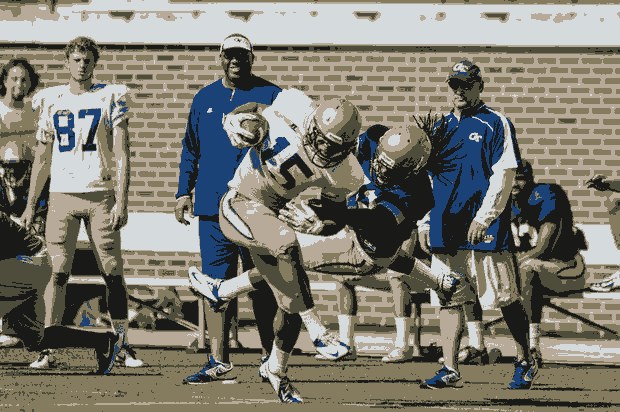

In [556]:

k = 6
def k_means(X, k, max_iters=1000):
    points, _  = X.shape

    centroids = X[np.random.choice(points, k, replace=False)]
    iterations = 0
    for _ in range(max_iters):
 
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        iterations += 1

        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels, iterations



start_time = time.time()
centroids, labels, iterations = k_means(pixels, k)
print("--- %s seconds ---" % (time.time() - start_time))
print("Iterations:", iterations)
centroid = np.array([list(centroids[label]) 
                           for label in labels])

centroid = centroid.astype("uint8")
centroids_reshaped = np.reshape(centroid, (image.height, image.width, 3), "C")
compressed_im = Image.fromarray(centroids_reshaped)
compressed_im

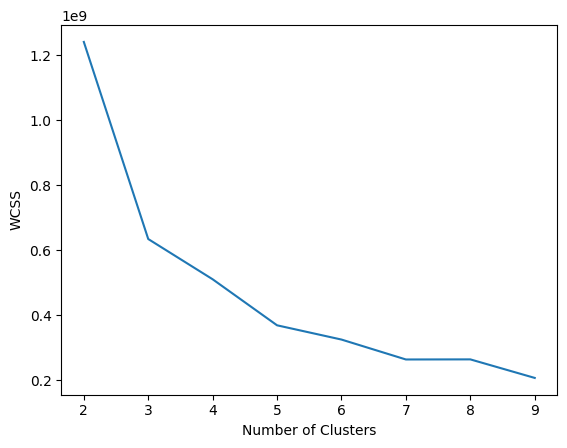

In [558]:
sse = []

for k in range(2, 10):
    centroids, labels, iterations = k_means(pixels, k)
    
    wcss = 0
    for id in np.unique(labels):
        
        cluster = pixels[labels == id]

        distances = np.linalg.norm(cluster - centroids[id], axis=1)
        squared_distances = distances ** 2

        cluster_wcss = np.sum(squared_distances)

        wcss += cluster_wcss
    sse.append(wcss)


#visualize results
plt.plot(range(2, 10), sse)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

# HW 1-4 MNIST Dataset Clustering

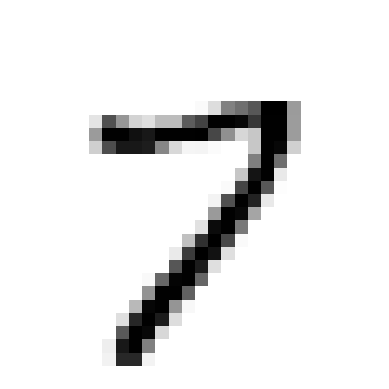

7


In [27]:
import scipy.io
from sklearn import metrics
from sklearn.cluster import KMeans

mat = scipy.io.loadmat('data/mnist_10digits.mat')

xtrain = mat['xtrain']/255
xtrain = xtrain.reshape(len(xtrain),-1)

ytrain = mat['ytrain']
ytrain = ytrain.reshape(len(ytrain),-1)


some_digit = xtrain[30001] 
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = plt.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

print(ytrain[0,30001])

In [471]:
def k_means(X, k, max_iters=150):
    n, _ = X.shape
    centroids = X[np.random.choice(n, k, replace=False)]
    iterations = 0
    labels = np.empty(n)

    for _ in range(max_iters):
        for i, point in enumerate(X):
            #distances_euclid = np.linalg.norm(point - centroids, axis=1)
            distances_manhattan = np.sum(np.abs(point - centroids), axis=1)
            # https://nicholasvadivelu.com/2021/05/10/fast-k-means/
            labels[i] = np.argmin(distances_manhattan)
    
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        iterations += 1
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids
 
    return centroids, labels, iterations

k = 10
centroids, labels, iterations = k_means(xtrain, k)




In [473]:
# https://stackoverflow.com/questions/34047540/python-clustering-purity-metric

def purity_score(y_true, y_pred,index):
    cont_mat = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.amax(cont_mat[index], axis=0) / np.sum(cont_mat[index]) 
m = []
for i in range(k):
    print(purity_score(ytrain,labels,i), "\n")
    m.append(purity_score(ytrain,labels,i))
np.mean(m)

0.4230964038494006 

0.9973301690892911 

0.4405840886203424 

0.42635785353123473 

0.4282779869907566 

0.3527024534218779 

0.6083136194660358 

0.6766161213088587 

0.40266621090411897 

0.506471675911918 



0.5262416583093834

# HW 1-5 Political Blog Dataset

In [559]:
import pandas as pd
import networkx as nx
import numpy as np

nodes = pd.read_table("data/nodes.txt",names=["Node", "Verticies", "Political Orien", "NA"])
edges = pd.read_table("data/edges.txt",names=["V1",'V2']).drop_duplicates()
edges1 = list(edges.itertuples(index=False, name=None))


In [560]:
# https://stackoverflow.com/questions/48820586/removing-isolated-vertices-in-networkx 

G = nx.Graph()
n = nodes.Node
e = edges1

G.add_nodes_from(n)
G.add_edges_from(e)

subgraph = G.subgraph(n)

connected_components = list(nx.connected_components(subgraph))
    
largest_component = max(connected_components, key=len)
    
new_graph = G.subgraph(largest_component)

ed = np.array(new_graph.edges)
nod = np.array(new_graph.nodes) - 1
nod =nodes.iloc[nod]


A = nx.adjacency_matrix(new_graph)
A = A.toarray()



/var/folders/1p/cp6mx14s7fbcxp3s3vtxppl00000gn/T/ipykernel_828/593452668.py:23: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(new_graph)


In [561]:
# test_football course example code

D = np.diag(np.asarray(1/np.sqrt(np.sum(A,axis=1))).ravel())
L = D @ A @ D
L = np.array(L)


In [562]:
eigvals, eigvecs = np.linalg.eig(L)
k=2

idx = np.argsort(eigvals)
eigvecs = eigvecs[:,idx[-k:]]
eigvecs = eigvecs.real

comp = KMeans(n_clusters=k,n_init=10).fit(eigvecs)


In [563]:

cluster_assignments = comp.labels_
data_labels = nod["Political Orien"]
unique_clusters = np.unique(cluster_assignments)

majority_labels = {}
label_counts = {}
majority_labels = {}
overall = []
majority_label_counts = {}


for cluster_id in unique_clusters:
    
    data_in_cluster = data_labels[cluster_assignments == cluster_id]


    majority_label = np.argmax(np.bincount(data_in_cluster))
    majority_labels[cluster_id] = majority_label

    data_in_cluster = data_labels[cluster_assignments == cluster_id]
    
    majority_count = np.sum(data_in_cluster == majority_label)
    majority_label_counts[cluster_id] = majority_count

    label_counts[cluster_id] = len(data_in_cluster)

for cluster_id, majority_label in majority_labels.items():
    count = majority_label_counts[cluster_id]
    length = len(data_labels[cluster_assignments == cluster_id])
    overall.append((1-count/length)*length)
    print(f"Cluster {cluster_id}: Majority Label = {majority_label}, Label Count = {length}, Majority Count = {count}, Mismatch = {1-count/length}")
    
print(np.sum(overall)/1222)

Cluster 0: Majority Label = 1, Label Count = 1218, Majority Count = 632, Mismatch = 0.4811165845648604
Cluster 1: Majority Label = 1, Label Count = 4, Majority Count = 4, Mismatch = 0.0
0.4795417348608838


cluster #: 2 , 47.95417348608838
cluster #: 3 , 22.913256955810144
cluster #: 4 , 4.90998363338789
cluster #: 5 , 4.3371522094926345
cluster #: 6 , 4.418985270049099
cluster #: 7 , 12.765957446808512
cluster #: 8 , 4.418985270049103
cluster #: 9 , 5.482815057283143
cluster #: 10 , 4.173486088379707
cluster #: 11 , 4.173486088379703
cluster #: 12 , 7.283142389525371
cluster #: 13 , 10.39279869067103
cluster #: 14 , 9.901800327332243
cluster #: 15 , 10.065466448445175
cluster #: 16 , 8.674304418985269
cluster #: 17 , 8.101472995090017
cluster #: 18 , 4.909983633387889
cluster #: 19 , 5.319148936170213
cluster #: 20 , 11.04746317512275
cluster #: 21 , 10.88379705400982
cluster #: 22 , 5.073649754500817
cluster #: 23 , 10.392798690671032
cluster #: 24 , 5.482815057283145


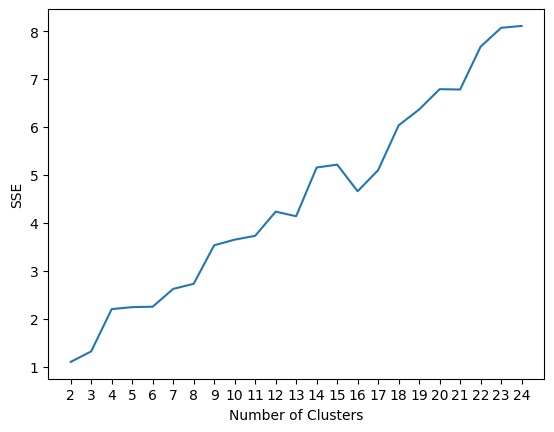

In [524]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 3,
}
sse = []
for k in range(2, 25):
    eigvals, eigvecs = np.linalg.eig(L)
    idx = np.argsort(eigvals)
    eigvecs = eigvecs[:,idx[-k:]]
    eigvecs = eigvecs.real
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(eigvecs)
    sse.append(kmeans.inertia_)


    cluster_assignments = kmeans.labels_
    data_labels = nod["Political Orien"]
    unique_clusters = np.unique(cluster_assignments)
    
    # Initialize
    majority_labels = {}
    label_counts = {}
    majority_labels = {}
    overall = []
    majority_label_counts = {}

    for cluster_id in unique_clusters:

        data_in_cluster = data_labels[cluster_assignments == cluster_id]
        
        majority_label = np.argmax(np.bincount(data_in_cluster))
        majority_labels[cluster_id] = majority_label
    
        data_in_cluster = data_labels[cluster_assignments == cluster_id]
        
        majority_count = np.sum(data_in_cluster == majority_label)
        majority_label_counts[cluster_id] = majority_count
    
        label_counts[cluster_id] = len(data_in_cluster)
    
    for cluster_id, majority_label in majority_labels.items():
        count = majority_label_counts[cluster_id]
        length = len(data_labels[cluster_assignments == cluster_id])
        overall.append((1-count/length)*length)
    print("cluster #:",k,",", np.sum(overall)/1222*100)


plt.plot(range(2, 25), sse)
plt.xticks(range(2, 25))
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()


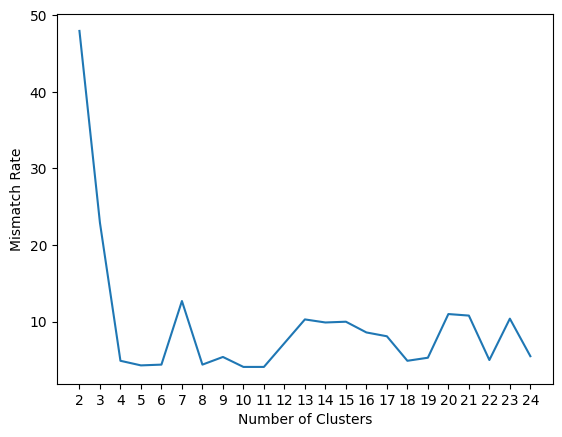

In [553]:
ov = [47.95,22.91,4.9,4.3,4.4,12.7,4.4,5.4,4.1,4.1,7.2,10.3,9.9,10,8.6,8.1,4.9,5.3,11,10.8,5.0,10.4,5.5]

plt.plot(range(2, 25), ov)
plt.xticks(range(2, 25))
plt.xlabel("Number of Clusters")
plt.ylabel("Mismatch Rate")
plt.show()